In [166]:
# import necessary packages
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from arch.univariate import ARX, GARCH, EGARCH, ConstantMean, StudentsT, SkewStudent

Using `pandas_datareader` to download daily prices for the S&P 500 index from Yahoo!, beginning in 1980. Construct a return series.

<AxesSubplot:xlabel='Date'>

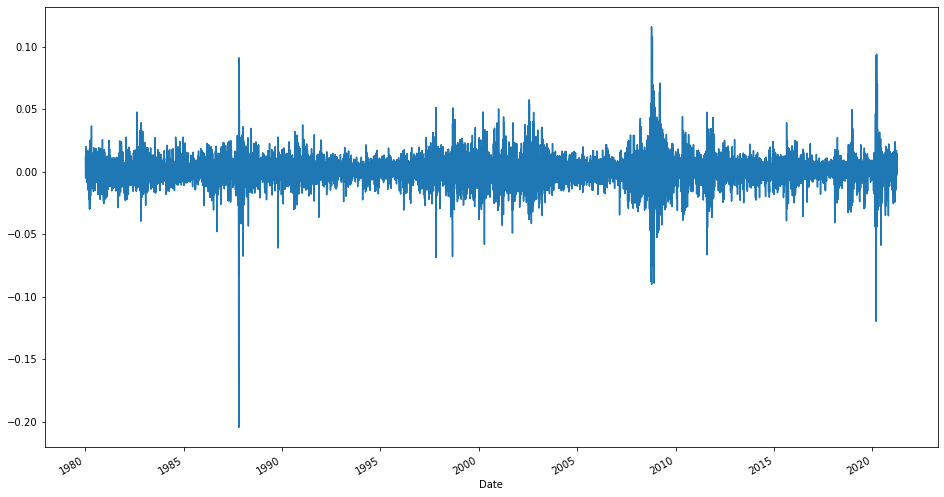

In [167]:
sp500 = pdr.get_data_yahoo('^GSPC', 1980)

sp500['daily_returns'] = sp500['Adj Close'].pct_change(1)

sp500.dropna(inplace=True)

sp500_rets = sp500['daily_returns']

fig, (ax1) = plt.subplots(1,1,figsize=(16,9))

sp500_rets.plot(ax=ax1, label='Index')

## Markov switching model of daily returns

Import the `MarkovAutoregression` class.

In [168]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression

Estimate a Markov Switching model with 2 regimes and 3 AR lags. Allow the AR coefficients and the variance of the noise term to be different in the different regimes.

Note: This model may take at least 30 seconds to solve. You should get a log likelihood of about 33,770.

In [169]:
# modsel = ar_select_order(sp500["daily_returns"], maxlag=12, old_names=False, ic='aic')
# modsel.ar_lags
# modsel.bic

In [170]:
def print_loglik(params):
    # transform parameters for input to log-likelihood
    params = sp500_mod.transform_params(params)
    print('loglik: {:.4f}'.format(sp500_mod.loglike(params)))

In [186]:
#Model without switching autocorrelation coefficients
# sp500_mod = MarkovAutoregression(sp500_rets, k_regimes=2, order=3, switching_ar=False)

# sp500_res = sp500_mod.fit(disp=True, em_iter=15, search_reps=25, search_iter=10,
#                             callback=print_loglik)
# print(sp500_res.summary())

In [191]:
#Model with switching autocorrelations
sp500_mod_1 = MarkovAutoregression(sp500_rets, k_regimes=2, order=3, switching_ar=True, switching_variance=True)

sp500_res_1 = sp500_mod_1.fit(disp=True, em_iter=15, search_reps=25, search_iter=10,
                            callback=print_loglik)
print(sp500_res_1.summary())

C:\Users\Edward\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


loglik: 29300.2530
loglik: 29287.6538
loglik: 29273.2222
loglik: 29252.6510
loglik: 29213.8626
loglik: 29134.1160
loglik: 29015.7670
loglik: 29021.7808
loglik: 29029.8915
loglik: 29042.0016
loglik: 29055.6534
loglik: 29058.9964
loglik: 29058.1580
loglik: 29050.5296
loglik: 29028.1758
loglik: 28974.3495
loglik: 28954.2750
loglik: 28937.5822
loglik: 28939.3183
loglik: 28941.5221
loglik: 28944.4940
loglik: 28948.6407
loglik: 28954.0505
loglik: 28956.1557
loglik: 28955.8041
loglik: 28951.9006
loglik: 28941.7664
loglik: 28935.4039
loglik: 28933.6437
loglik: 28934.9445
loglik: 28935.7563
loglik: 28936.0782
loglik: 28936.1579
loglik: 28936.1640
loglik: 28936.1507
loglik: 28936.1380
loglik: 28936.1342
Optimization terminated successfully.
         Current function value: -3.246942
         Iterations: 37
         Function evaluations: 45
         Gradient evaluations: 45
                         Markov Switching Model Results                         
Dep. Variable:            daily_returns   N

Carefully interpret the results. Be sure to discuss the following:

- If you had to give each regime a name, what would you call them?
- What are the $\sigma^2_i$ in each regime? What is the magnitude of the difference?
- How are the autocorrelations different between the regimes?

(Please do not write your answer in a comment. Use the markdown cell below to write a nicely-formatted answer.)

- I would name Regime 1 the recession regime or the high volatility regime, since the constant coefficient is negative, and the returns estimated by the regression equation while in that state will be lower than the typical estimated returns. The standard error is also much higher for this regime, reflecting the increased volatility in this state. Regime 0 would be the normal regime, since it reflects an average daily return in a regular volatility state with a lower constant coefficient. 
- The sigma^2 in regime 1 is .0004, and .00005175 for regime 0, making it approximately a single order of magnitude greater in the high volatility regime.
- The first lag is noticeably different between the two regimes, as it has a very significant z-score in regime 1 while having a very insignificant p-value in regime 0, making the previous day much more relevant in estimating the current return during recessionary periods than normal. The coefficient is also very low for the first lag in regime, and has a bigger impact on the regression equation than any other variable in the model. Interestingly, the second and third lags are both insignificant for regime 0 but are somewhat significant for regime 0, yet the values for each of these lags in the 'normal' period are negative.

What is the estimated transition probability matrix?

In [194]:
#Viewing values
transition_table = sp500_res_1.summary().tables[3]
transition_df = pd.DataFrame(transition_table)
transition_df

,0,1,2,3,4,5,6
0,,coef,std err,z,P>|z|,[0.025,0.975]
1,p[0->0],0.9871,0.002,529.065,0.000,0.983,0.991
2,p[1->0],0.0450,0.007,6.731,0.000,0.032,0.058


In [195]:
#Creating a matrix
stay_zero = .9871
leave_zero = 1-stay_zero
leave_one = .045
stay_one = 1-leave_one

transition_matrix = np.array([stay_zero,leave_zero,leave_one,stay_one]).reshape(2,2)
transition_matrix

array([[0.9871, 0.0129],
       [0.045 , 0.955 ]])

How long should we expect each of the regimes to last?

In [173]:
print(sp500_res.expected_durations)

[  1.13605375 174.00859492]


We can expect regime 0 to last for approximately one day, while regime 1 will last for about 174 days.

Resample the *filtered marginal probabilities* for regime 1 at a semi-annual basis (using a resample frequency `2Q`). Plot the mean over time. Does the figure match what you would expect?

Date
1980-03-31    AxesSubplot(0.125,0.2;0.775x0.68)
1980-09-30    AxesSubplot(0.125,0.2;0.775x0.68)
1981-03-31    AxesSubplot(0.125,0.2;0.775x0.68)
1981-09-30    AxesSubplot(0.125,0.2;0.775x0.68)
1982-03-31    AxesSubplot(0.125,0.2;0.775x0.68)
                            ...                
2019-09-30    AxesSubplot(0.125,0.2;0.775x0.68)
2020-03-31    AxesSubplot(0.125,0.2;0.775x0.68)
2020-09-30    AxesSubplot(0.125,0.2;0.775x0.68)
2021-03-31    AxesSubplot(0.125,0.2;0.775x0.68)
2021-09-30    AxesSubplot(0.125,0.2;0.775x0.68)
Freq: 2Q-DEC, Name: 0, Length: 84, dtype: object

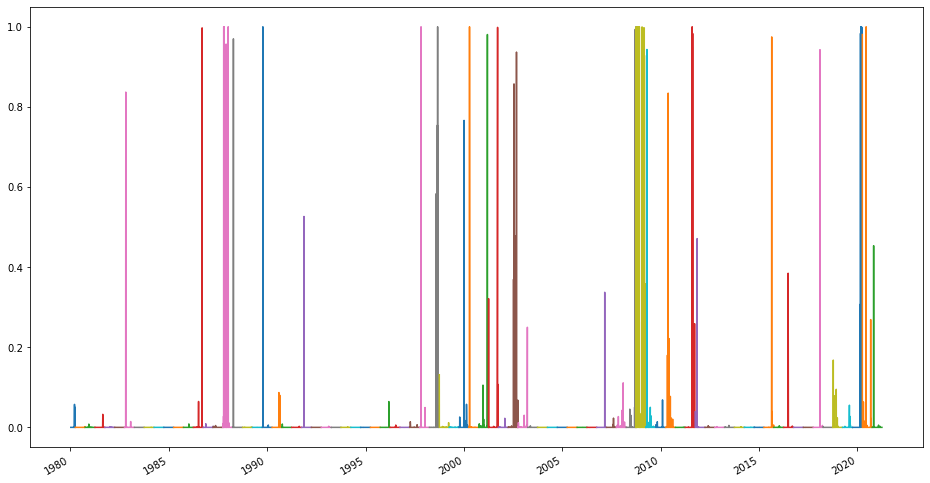

In [174]:
sp500_res.filtered_marginal_probabilities[0].resample("2Q").plot(figsize=(16,9))

The figure matches what I would expect, as periods with recessions or high volatility all have a very high probability of being in regime 0.

What is the probability that we are currently in regime 1?

In [175]:
probs=sp500_res.filtered_marginal_probabilities[0]
probs[-1]

4.2026440143314357e-10

Calculate the 15-day rolling volatility of the return series. Call this series `rvol`. Plot it.

<AxesSubplot:xlabel='Date'>

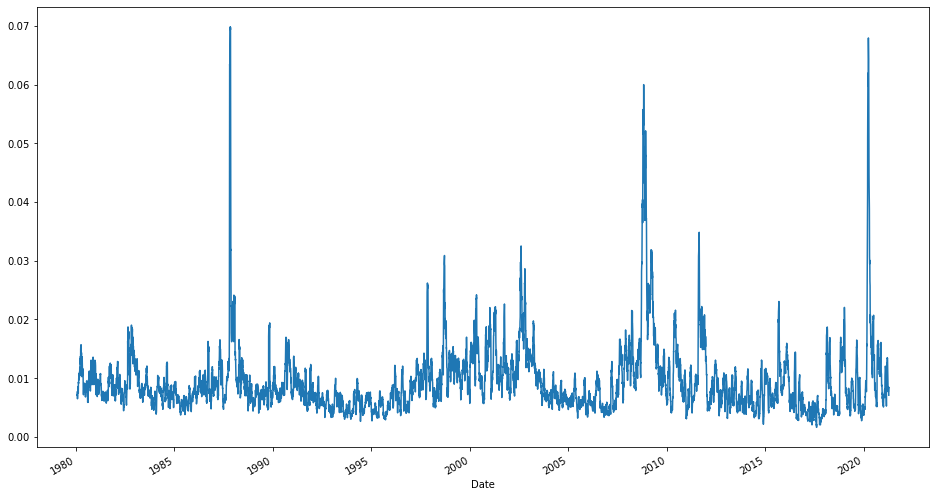

In [176]:
#ax = sp500_rets.plot(figsize=(16,9))

rvol = sp500_rets.rolling(15).std()

rvol.plot(figsize=(16,9))

We can merge this series with the probabilities of regime 1 from the model using this code:

In [177]:
merged_df = pd.merge(rvol, sp500_res.filtered_marginal_probabilities[1], left_index=True, right_index=True)
merged_df.dropna(inplace=True)
merged_df

,daily_returns,1
Date,,
1980-01-23,0.007629,1.0
1980-01-24,0.007174,1.0
1980-01-25,0.007040,1.0
1980-01-28,0.007222,1.0
1980-01-29,0.006483,1.0
...,...,...
2021-04-05,0.008482,1.0
2021-04-06,0.008436,1.0
2021-04-07,0.008386,1.0


Use this DataFrame to calculate the *Spearman rank correlation* of the two series. (Consult the documentation if necessary.)

Interpret the value of this correlation.

In [178]:
coef, p = spearmanr(merged_df["daily_returns"], merged_df[1])
coef

0.01649725580500654

The correlation coefficient is very close to zero, meaning that there is very little correlation between the rolling volatility in the dataset and the probability of being in regime 1.

## GARCH model of monthly returns

Calculate a monthly return series. Drop the last month, which is incomplete.

In [179]:
dates = []
adj_closes = []

current_month = 0

for index, row in sp500.iterrows():
    month = index.month
    if month != current_month:
        dates.append(index)
        adj_closes.append(row["Adj Close"])
        current_month = month
    else:
        pass

In [180]:
monthly_closes = pd.DataFrame(data=adj_closes, index=dates, columns=["Adj Close"])
monthly_closes["monthly_returns"] = monthly_closes['Adj Close'].pct_change(1)
monthly_closes.dropna(inplace=True)
monthly_closes

,Adj Close,monthly_returns
1980-02-01,115.120003,0.094089
1980-03-03,112.500000,-0.022759
1980-04-01,102.180000,-0.091733
1980-05-01,105.459999,0.032100
1980-06-02,110.760002,0.050256
...,...,...
2020-12-01,3662.449951,0.106400
2021-01-04,3700.649902,0.010430
2021-02-01,3773.860107,0.019783
2021-03-01,3901.820068,0.033907


In [181]:
monthly_returns = monthly_closes["monthly_returns"] * 100
monthly_returns

1980-02-01     9.408859
1980-03-03    -2.275888
1980-04-01    -9.173333
1980-05-01     3.210020
1980-06-02     5.025605
                ...    
2020-12-01    10.640013
2021-01-04     1.043016
2021-02-01     1.978307
2021-03-01     3.390692
2021-04-01     3.025512
Name: monthly_returns, Length: 495, dtype: float64

Estimate an AR(3)–GARCH(1,1) with monthly returns.

Write out the equations for the return model, including only the variables that are significant at a 10% level (that is, with p-values less than 0.1).

In [182]:
model1 = ARX(monthly_returns,lags=3)
model1.volatility = GARCH(p=1,q=1)
res1 = model1.fit(disp='on')
print(res1.summary())

Iteration:      1,   Func. Count:      9,   Neg. LLF: 13841.02857171283
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3145.7982679616707
Iteration:      3,   Func. Count:     30,   Neg. LLF: 3584.5881773258407
Iteration:      4,   Func. Count:     41,   Neg. LLF: 1849.1009414020211
Iteration:      5,   Func. Count:     51,   Neg. LLF: 2429.944592367466
Iteration:      6,   Func. Count:     61,   Neg. LLF: 1420.6230077341747
Iteration:      7,   Func. Count:     71,   Neg. LLF: 1402.4278993928401
Iteration:      8,   Func. Count:     80,   Neg. LLF: 1491.6349947399458
Iteration:      9,   Func. Count:     89,   Neg. LLF: 1401.4810059215151
Iteration:     10,   Func. Count:     97,   Neg. LLF: 1401.4793249446816
Iteration:     11,   Func. Count:    105,   Neg. LLF: 1401.4790430436042
Iteration:     12,   Func. Count:    113,   Neg. LLF: 1401.4790407916253
Iteration:     13,   Func. Count:    120,   Neg. LLF: 1401.4790407921973
                           AR - GARCH Model Results  

Each of the lag coefficients, except for the constant, are insignificant at a 10% level based on their p-values, so the equation for the return model would not include the coefficients for any lags. The equations for the entire model would be:

$$r_t = 0.9163 + \epsilon_t,$$

and

$$\sigma_t^2 = 0.8274 + 0.1393 \epsilon_{t-1}^2 + 0.8317 \sigma_{t-1}^2.$$





Plot the conditional volatility from the model.

<AxesSubplot:>

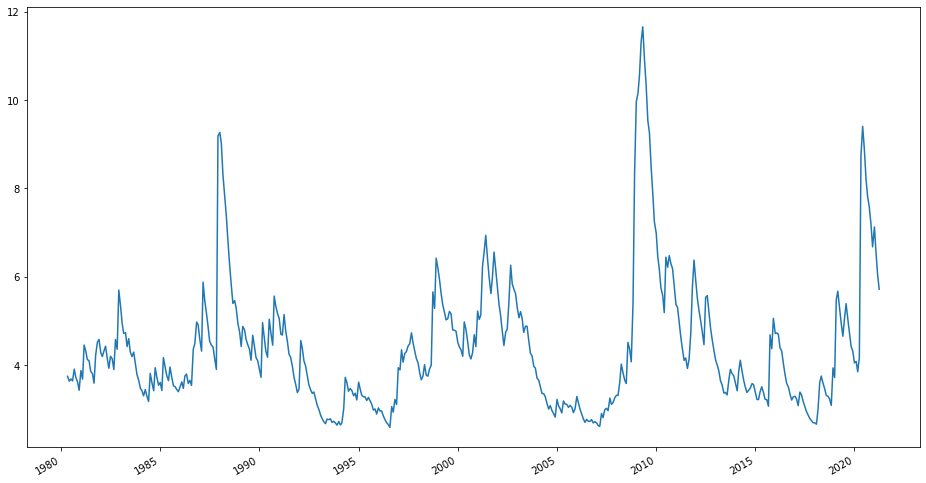

In [184]:
res1.conditional_volatility.plot(figsize=(16,9))

Discuss the similarities and differences of:
- calculating a rolling volatility of daily returns
- estimating the $\sigma_t^2$ in a GARCH model using monthly returns.

Why might one of these approaches be better than the other?

A rolling volatility would be similar to estimating the monthly volatility in a GARCH model in that each would capture the level of deviation at a particular point by taking into account recent data. However, the rolling volatility would be weighing each of the previous days equally, and the amount of previous days accounted for is likely to be chosen abritrarily, which means it is unlikely to be a very accurate reflection of the estimated volatility on a given day. With the GARCH model, the number of epsilon and sigma lags can be chosen by an AIC or BIC approach in order to keep the previous datapoints which correlate with the current day's volatility. Also, with the alpha and beta terms being estimated by the GARCH model, it offers a more precise value for the importance that each previous day's shock and volatility has on the current volatility. Because of the GARCH's usefulness in factoring in shocks, a clearer justification for the number of lags chosen and weights determined by alpha and beta, it would seem like a GARCH approach is more effective than taking a rolling volatility of daily returns.